In [ ]:
#final goal - model of atmospheric temperature using following forcings and including following feedbacks, where you can toggle human behavior and see how the future looks
#Milankovitch cycles as solar irradiation forcings
#Human agriculture and fossil fuel emmission also irradiation forcings increasing absorbitivity
#including ice albedo, water vapor, and planck feedbacks
#also including residence time of CO2 and water vapor to see how long it takes to get back to another glacial maximum
#Hi Everyone! For my final project I built an interactive simulation of the earth’s climate!
#The basic elements of this simulation are pretty straightforward, I’ve included 5(7 if you split up milankovitch) forcings you can control, with default values of our best current predictions of how they act, and 3 internal feedbacks. The forcings, as you can see, are partially anthropogenic and partially giving you the powers of a god to reshape the world as you desire
#To identify the baseline values for the simulation, I searched academic literature for the values of variables
#Scan the barcode here to mess around with the simulation on your phone! I challenge you to cause a runaway greenhouse effect without changing the amount of energy the sun emits!



In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

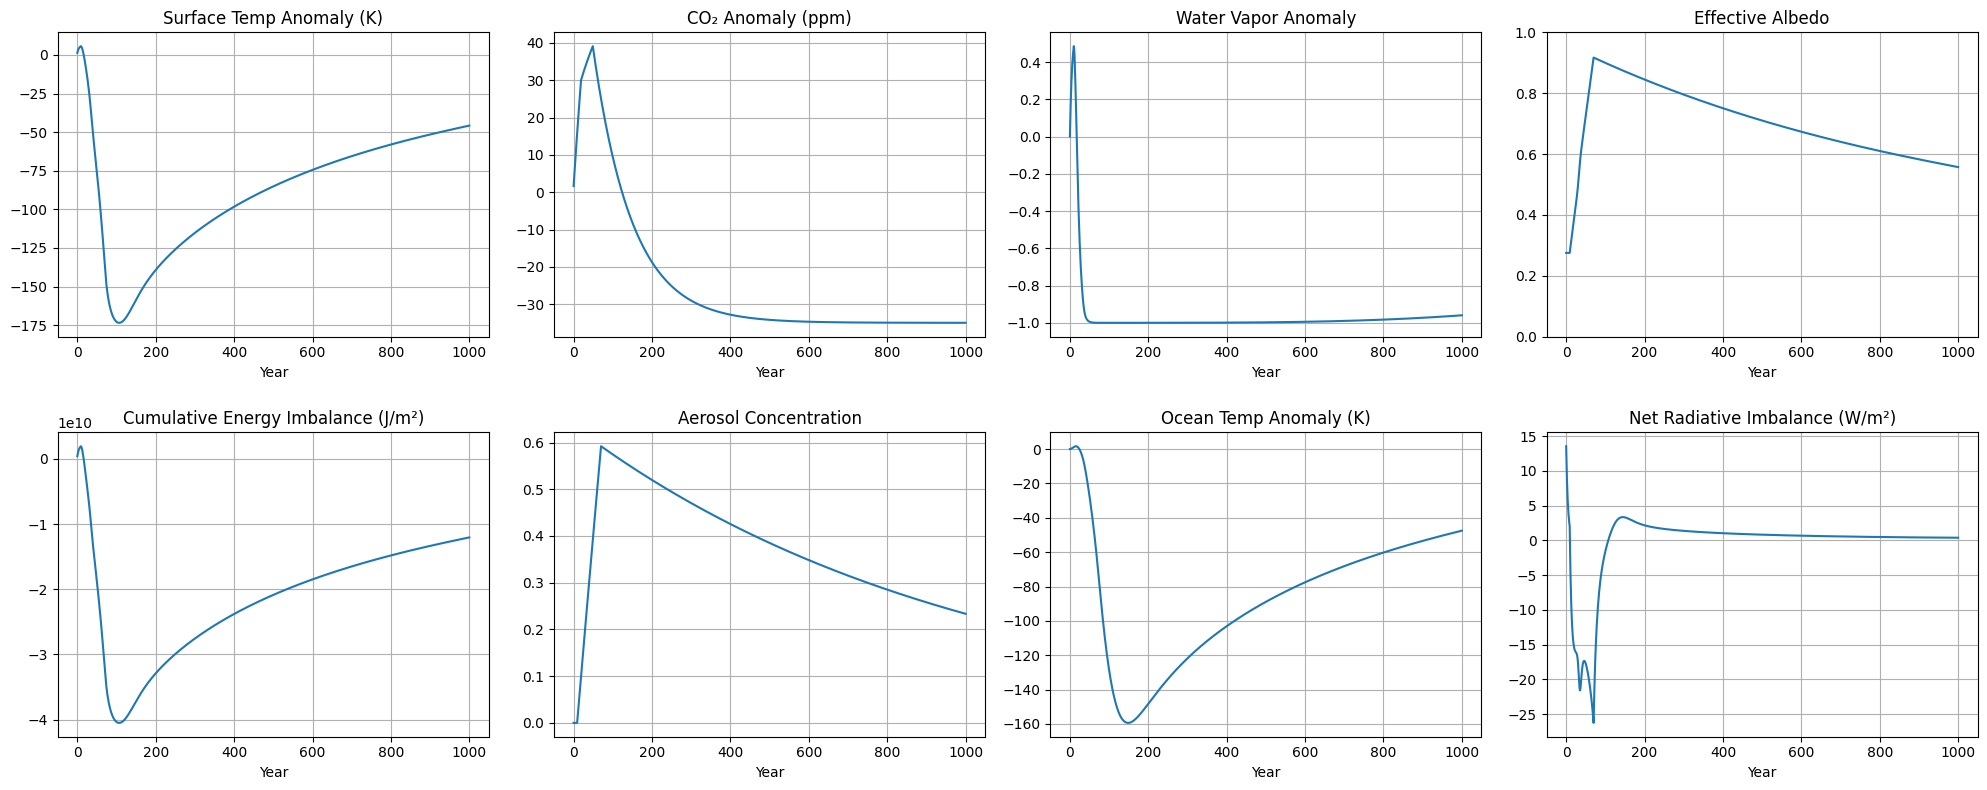

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Constants ===
sigma = 5.67e-8
S0 = 1361
dt = 365 * 24 * 3600  # 1 year in seconds
years = np.arange(0, 1001)

# Heat capacities (J/m²/K)
C_surface = 1e8
C_ocean = 5e9
frac_surface = 0.3
frac_ocean = 0.7

# === Initial Planetary State ===
planet_state = {
    'surface_temp': 288.0,           # K
    'ocean_temp': 288.0,             # K
    'co2_ppm': 415.0,                # ppm
    'water_vapor': np.exp(0.07 * (288 - 288)),  # = 1.0
    'albedo': 0.3,                   # baseline before feedbacks
    'aerosol_conc': 0.0              # sulfate aerosol concentration
}
# === Baseline Values ===
T_baseline = planet_state['surface_temp']
T_ocean_baseline = planet_state['ocean_temp']
co2_baseline = planet_state['co2_ppm']
wv_baseline = planet_state['water_vapor']
baseline_emissivity = 0.612
net_flux_baseline = None  # we'll calculate this in year 0
outgoing_baseline = None
emissivity_baseline = None
feedback_multiplier_baseline = None


history = {
    'year': [],
    'surface_temp': [],
    'ocean_temp': [],
    'co2_ppm': [],
    'water_vapor': [],
    'net_flux': [],
    'outgoing': [],
    'emissivity': [],
    'feedback_multiplier': [],
    'aerosol_conc': [],
    'albedo': []
}


# === Forcing and Feedback Functions ===
def insolation(increase=0):
    return S0 + increase

def update_water_vapor(surface_temp):
    """
    Water vapor feedback modeled to match IPCC estimate: roughly 7%/K.
    Baseline = 1.0 at 288 K.
    """
    return np.exp(0.07 * (surface_temp - 288))



def compute_emissivity(co2_ppm, water_vapor):
    co2_effect = np.log(co2_ppm / 280)
    h2o_effect = np.log(water_vapor)  # logarithmic, like CO₂
    opacity = 0.04 * co2_effect + 0.07 * h2o_effect
    return baseline_emissivity / (1 + opacity)


def ice_albedo_feedback(T_surface, geo_albedo=0.3):
    """
    Returns a dynamic albedo.
    High at cold temps (snow/ice), drops as planet warms.
    """
    T0 = 288  # current climate reference
    ice_thresh = 260  # glacial state
    no_ice_thresh = 295  # ice-free world

    # sigmoid-style smooth transition
    return geo_albedo + 0.025 * np.tanh((ice_thresh - T_surface) / 10)


def outgoing_energy(T, emissivity):
    return emissivity * sigma * T**4

def incoming_energy(albedo):
    # Effective absorbed solar radiation
    return insolation() * (1 - albedo) * 0.252  # or 240/953

def update_co2(co2_ppm, T_surface, dt_years, year, damping=0.01):
    emissions = anthropogenic_emissions(year)
    drawdown = max(damping * (co2_ppm - 280),0)
    delta_co2 = (emissions - drawdown) * dt_years
    return co2_ppm + delta_co2

# === Geoengineering Parameters ===
def make_geoengineered_albedo(start_year=10, end_year=70, injection_rate=0.01, decay_rate=0.001, max_effect=1):
    aerosol_conc = 0.0

    def geoengineered_albedo(natural_albedo, year):
        nonlocal aerosol_conc
        aerosol_conc *= (1 - decay_rate)
        if start_year <= year <= end_year:
            aerosol_conc += injection_rate
        albedo = natural_albedo + np.clip(aerosol_conc, 0, 1) * max_effect
        return albedo, aerosol_conc

    return geoengineered_albedo



def anthropogenic_emissions(year):
    if year < 20:
        return 3.0  # Business as usual
    elif year < 50:
        return 2.0  # Stabilization
    else:
        return 1.0  # Decline due to mitigation


def positive_feedback(surface_temp):
    T0 = 288
    dT = 10
    water_amp = 0.3
    ice_amp = 0.2
    f = water_amp * np.tanh((surface_temp - T0) / dT)
    f += ice_amp * np.tanh((surface_temp - T0) / (2 * dT))
    return f  # centered at 0

def negative_feedback(surface_temp):
    T0 = 288
    dT = 15
    planck_damp = 0.6
    cloud_reflect = 0.4
    f = -planck_damp * np.tanh((surface_temp - T0) / dT)
    f -= cloud_reflect * np.tanh((surface_temp - T0) / (2 * dT))
    return f  # centered at 0


# === Baseline Values ===
T_baseline = planet_state['surface_temp']
T_ocean_baseline = planet_state['ocean_temp']
co2_baseline = planet_state['co2_ppm']
wv_baseline = planet_state['water_vapor']
net_flux_baseline = None  # we'll calculate this in year 0
outgoing_baseline = None
emissivity_baseline = None
feedback_multiplier_baseline = None



# === Simulation Loop ===
geoengineered_albedo = make_geoengineered_albedo()

for year in years:
    T_surface = planet_state['surface_temp']
    T_ocean = planet_state['ocean_temp']
    co2 = planet_state['co2_ppm']
    natural_albedo = ice_albedo_feedback(T_surface)
    albedo, aerosol_conc = geoengineered_albedo(natural_albedo, year)

    # Update dependent variables
    water_vapor = update_water_vapor(T_surface)
    emissivity = compute_emissivity(co2, water_vapor)
    incoming = incoming_energy(albedo)
    outgoing = outgoing_energy(T_surface, emissivity)
    net_flux = incoming - outgoing

    # Feedback-modified climate sensitivity
    fb = positive_feedback(T_surface) + negative_feedback(T_surface)
    multiplier = 1 + fb
    eff_C_surface = C_surface / multiplier
    eff_C_ocean = C_ocean / multiplier

    # Temperature changes
    dT_surface = (net_flux * frac_surface * dt) / eff_C_surface
    dT_ocean = (net_flux * frac_ocean * dt) / eff_C_ocean

    # Update state
    planet_state['surface_temp'] += dT_surface
    tau_ocean = 30  # ocean adjustment timescale in years
    planet_state['ocean_temp'] += (T_surface - T_ocean) / tau_ocean
    planet_state['water_vapor'] = water_vapor
    planet_state['albedo'] = albedo
    planet_state['aerosol_conc'] = aerosol_conc

    planet_state['co2_ppm'] = update_co2(
        planet_state['co2_ppm'],
        planet_state['surface_temp'],
        dt_years=1.0,
        year=year,
        damping=0.01  # adjustable
    )
    #print(f"Year {year} | net_flux = {net_flux:.2f} W/m² | dT_surface = {dT_surface:.2f} K | emissivity = {emissivity:.3f}")


    # === Store History ===
    history['year'].append(year)
    for key in ['surface_temp', 'ocean_temp', 'co2_ppm', 'water_vapor', 'albedo', 'aerosol_conc']:
        history[key].append(planet_state[key])
    history['net_flux'].append(net_flux)
    history['outgoing'].append(outgoing)
    history['emissivity'].append(emissivity)
    history['feedback_multiplier'].append(multiplier)

    if 'cumulative_energy' not in history:
      history['cumulative_energy'] = []
      cumulative_energy = 0

    cumulative_energy += net_flux * dt  # Joules per m²
    history['cumulative_energy'].append(cumulative_energy)

    if year == 0:
      net_flux_baseline = net_flux
      outgoing_baseline = outgoing
      emissivity_baseline = emissivity
      feedback_multiplier_baseline = multiplier


# === Plot Results ===
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

axs[0].plot(history['year'], np.array(history['surface_temp']) - T_baseline)
axs[0].set_title("Surface Temp Anomaly (K)")

axs[1].plot(history['year'], np.array(history['co2_ppm']) - co2_baseline)
axs[1].set_title("CO₂ Anomaly (ppm)")

axs[2].plot(history['year'], np.array(history['water_vapor']) - wv_baseline)
axs[2].set_title("Water Vapor Anomaly")

axs[3].plot(history['year'], history['albedo'])
axs[3].set_title("Effective Albedo")
axs[3].set_ylim(0.0, 1)

axs[4].plot(history['year'], history['cumulative_energy'])
axs[4].set_title("Cumulative Energy Imbalance (J/m²)")

axs[5].plot(history['year'], history['aerosol_conc'])
axs[5].set_title("Aerosol Concentration")

#ocean temp
axs[6].plot(history['year'], np.array(history['ocean_temp']) - T_ocean_baseline)
axs[6].set_title("Ocean Temp Anomaly (K)")

axs[7].plot(history['year'], history['net_flux'])
axs[7].set_title("Net Radiative Imbalance (W/m²)")


for ax in axs:
    ax.set_xlabel("Year")
    ax.grid(True)

plt.tight_layout()
plt.show()


2025-04-25 19:17:19.396 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 19:17:19.556 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-25 19:17:19.557 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 19:17:19.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 19:17:19.563 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 19:17:19.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 19:17:19.565 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 19:17:19.566 Thread 'MainThread': mi

DeltaGenerator()

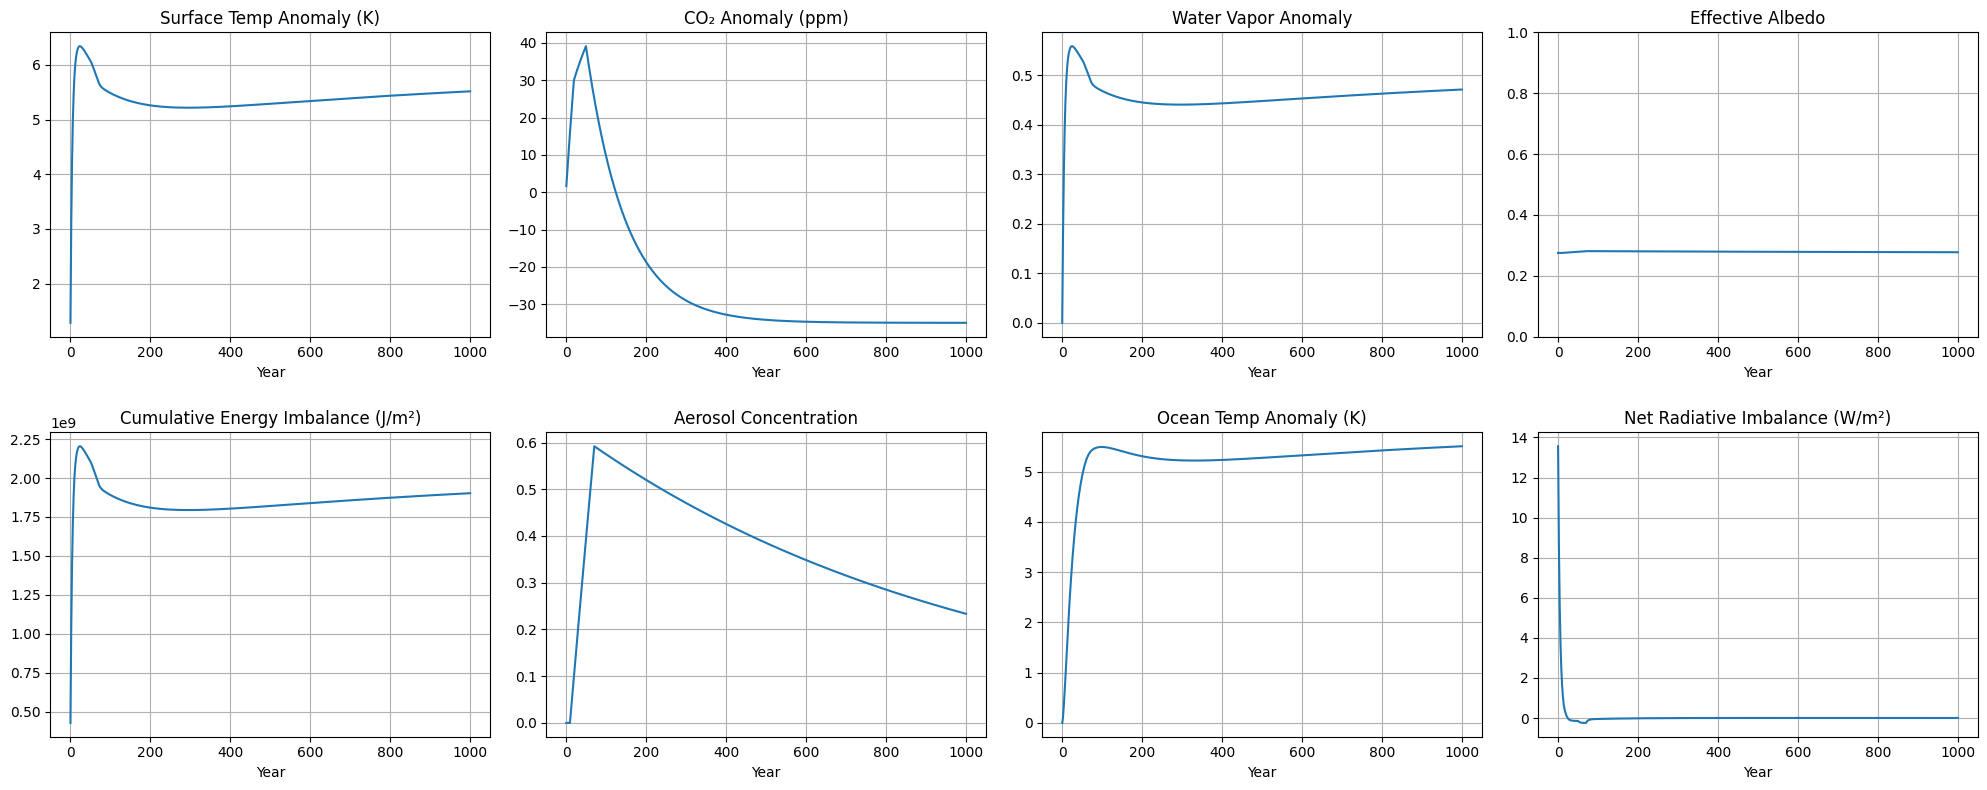

In [3]:
# save this as app.py

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt

# === Constants ===
sigma = 5.67e-8
S0 = 1361
dt = 365 * 24 * 3600  # 1 year in seconds
years = np.arange(0, 1001)
C_surface = 1e8
C_ocean = 5e9
frac_surface = 0.3
frac_ocean = 0.7
baseline_emissivity = 0.612

# === User Adjustable Parameters ===
st.title("Simple Climate Simulation 🌎☀️")

st.sidebar.header("Initial Conditions")
initial_surface_temp = st.sidebar.slider("Initial Surface Temperature (K)", 270.0, 310.0, 288.0)
initial_co2_ppm = st.sidebar.slider("Initial CO₂ Concentration (ppm)", 300.0, 500.0, 415.0)

st.sidebar.header("Geoengineering Options")
start_geo = st.sidebar.slider("Geoengineering Start Year", 0, 1000, 10)
end_geo = st.sidebar.slider("Geoengineering End Year", 0, 1000, 70)
injection_rate = st.sidebar.slider("Injection Rate", 0.0, 0.05, 0.01)
decay_rate = st.sidebar.slider("Decay Rate", 0.0, 0.01, 0.001)
max_effect = st.sidebar.slider("Max Albedo Effect", 0.0, 0.05, 0.01)

# === Initial Planetary State ===
planet_state = {
    'surface_temp': initial_surface_temp,
    'ocean_temp': initial_surface_temp,
    'co2_ppm': initial_co2_ppm,
    'water_vapor': np.exp(0.07 * (initial_surface_temp - 288)),
    'albedo': 0.3,
    'aerosol_conc': 0.0
}

# === History Storage ===
history = {key: [] for key in [
    'year', 'surface_temp', 'ocean_temp', 'co2_ppm', 'water_vapor',
    'net_flux', 'outgoing', 'emissivity', 'feedback_multiplier',
    'aerosol_conc', 'albedo', 'cumulative_energy'
]}

# === Forcing and Feedback Functions ===
def insolation(increase=0):
    return S0 + increase

def update_water_vapor(surface_temp):
    return np.exp(0.07 * (surface_temp - 288))

def compute_emissivity(co2_ppm, water_vapor):
    co2_effect = np.log(co2_ppm / 280)
    h2o_effect = np.log(water_vapor)
    opacity = 0.04 * co2_effect + 0.07 * h2o_effect
    return baseline_emissivity / (1 + opacity)

def ice_albedo_feedback(T_surface, geo_albedo=0.3):
    ice_thresh = 260
    no_ice_thresh = 295
    return geo_albedo + 0.025 * np.tanh((ice_thresh - T_surface) / 10)

def outgoing_energy(T, emissivity):
    return emissivity * sigma * T**4

def incoming_energy(albedo):
    return insolation() * (1 - albedo) * 0.252

def make_geoengineered_albedo(start_year, end_year, injection_rate, decay_rate, max_effect):
    aerosol_conc = 0.0
    def geoengineered_albedo(natural_albedo, year):
        nonlocal aerosol_conc
        aerosol_conc *= (1 - decay_rate)
        if start_year <= year <= end_year:
            aerosol_conc += injection_rate
        albedo = natural_albedo + np.clip(aerosol_conc, 0, 1) * max_effect
        return albedo, aerosol_conc
    return geoengineered_albedo

def anthropogenic_emissions(year):
    if year < 20:
        return 3.0
    elif year < 50:
        return 2.0
    else:
        return 1.0

def positive_feedback(surface_temp):
    return 0.3 * np.tanh((surface_temp - 288) / 10) + 0.2 * np.tanh((surface_temp - 288) / 20)

def negative_feedback(surface_temp):
    return -0.6 * np.tanh((surface_temp - 288) / 15) - 0.4 * np.tanh((surface_temp - 288) / 30)

def update_co2(co2_ppm, T_surface, dt_years, year, damping=0.01):
    emissions = anthropogenic_emissions(year)
    drawdown = max(damping * (co2_ppm - 280), 0)
    delta_co2 = (emissions - drawdown) * dt_years
    return co2_ppm + delta_co2

# === Simulation Loop ===
geoengineered_albedo = make_geoengineered_albedo(start_geo, end_geo, injection_rate, decay_rate, max_effect)

cumulative_energy = 0
for year in years:
    T_surface = planet_state['surface_temp']
    T_ocean = planet_state['ocean_temp']
    co2 = planet_state['co2_ppm']
    natural_albedo = ice_albedo_feedback(T_surface)
    albedo, aerosol_conc = geoengineered_albedo(natural_albedo, year)
    water_vapor = update_water_vapor(T_surface)
    emissivity = compute_emissivity(co2, water_vapor)
    incoming = incoming_energy(albedo)
    outgoing = outgoing_energy(T_surface, emissivity)
    net_flux = incoming - outgoing

    fb = positive_feedback(T_surface) + negative_feedback(T_surface)
    multiplier = 1 + fb
    eff_C_surface = C_surface / multiplier
    eff_C_ocean = C_ocean / multiplier

    dT_surface = (net_flux * frac_surface * dt) / eff_C_surface
    dT_ocean = (net_flux * frac_ocean * dt) / eff_C_ocean

    # Update state
    planet_state['surface_temp'] += dT_surface
    tau_ocean = 30
    planet_state['ocean_temp'] += (T_surface - T_ocean) / tau_ocean
    planet_state['water_vapor'] = water_vapor
    planet_state['albedo'] = albedo
    planet_state['aerosol_conc'] = aerosol_conc
    planet_state['co2_ppm'] = update_co2(co2, T_surface, 1.0, year)

    cumulative_energy += net_flux * dt

    # Save to history
    for key, value in {
        'year': year,
        'surface_temp': planet_state['surface_temp'],
        'ocean_temp': planet_state['ocean_temp'],
        'co2_ppm': planet_state['co2_ppm'],
        'water_vapor': planet_state['water_vapor'],
        'albedo': planet_state['albedo'],
        'aerosol_conc': planet_state['aerosol_conc'],
        'net_flux': net_flux,
        'outgoing': outgoing,
        'emissivity': emissivity,
        'feedback_multiplier': multiplier,
        'cumulative_energy': cumulative_energy
    }.items():
        history[key].append(value)

# === Plot Results ===
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

T_baseline = initial_surface_temp
co2_baseline = initial_co2_ppm
wv_baseline = np.exp(0.07 * (T_baseline - 288))

axs[0].plot(history['year'], np.array(history['surface_temp']) - T_baseline)
axs[0].set_title("Surface Temp Anomaly (K)")

axs[1].plot(history['year'], np.array(history['co2_ppm']) - co2_baseline)
axs[1].set_title("CO₂ Anomaly (ppm)")

axs[2].plot(history['year'], np.array(history['water_vapor']) - wv_baseline)
axs[2].set_title("Water Vapor Anomaly")

axs[3].plot(history['year'], history['albedo'])
axs[3].set_title("Effective Albedo")
axs[3].set_ylim(0.0, 1)

axs[4].plot(history['year'], history['cumulative_energy'])
axs[4].set_title("Cumulative Energy Imbalance (J/m²)")

axs[5].plot(history['year'], history['aerosol_conc'])
axs[5].set_title("Aerosol Concentration")

axs[6].plot(history['year'], np.array(history['ocean_temp']) - T_baseline)
axs[6].set_title("Ocean Temp Anomaly (K)")

axs[7].plot(history['year'], history['net_flux'])
axs[7].set_title("Net Radiative Imbalance (W/m²)")

for ax in axs:
    ax.set_xlabel("Year")
    ax.grid(True)

plt.tight_layout()
st.pyplot(fig)
